In [5]:
# food_keras_training.py
# Run: python food_keras_training.py
import os, json, math, pathlib
from collections import Counter

import numpy as np
import tensorflow as tf
from tensorflow import keras

# -------------------
# Basic config
# -------------------
DATA_DIR = pathlib.Path("dataset_split")  # change if needed
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR   = DATA_DIR / "val"
TEST_DIR  = DATA_DIR / "test"

# We'll load images as 256x256, then center-crop to 224 to preserve aspect ratio
LOAD_SIZE = (256, 256)
NET_SIZE  = (224, 224)   # EfficientNetB0 expected resolution

BATCH    = 32
EPOCHS_FROZEN   = 25
EPOCHS_FINETUNE = 18
SEED     = 1337

MODEL_OUT     = "food_efficientnet_b0.keras"
CLASSMAP_JSON = "class_names.json"

# Repro (best-effort)
tf.keras.utils.set_random_seed(SEED)
# Uncomment for strict determinism (slower):
# tf.config.experimental.enable_op_determinism = True

# Optional: mixed precision on recent GPUs
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy("mixed_float16")
    MIXED = True
except Exception:
    MIXED = False

# -------------------
# Datasets (force RGB; mixed sizes OK)
# -------------------
def make_ds(dir_path, shuffle=True):
    return tf.keras.utils.image_dataset_from_directory(
        dir_path,
        labels="inferred",
        label_mode="int",
        image_size=LOAD_SIZE,    # Resize loader output to 256x256 (no AR preservation here)
        batch_size=BATCH,
        shuffle=shuffle,
        seed=SEED,
        color_mode="rgb",        # <-- ensure 3 channels for ImageNet weights
    )

train_ds = make_ds(TRAIN_DIR, shuffle=True)
val_ds   = make_ds(VAL_DIR,   shuffle=False)
test_ds  = make_ds(TEST_DIR,  shuffle=False)

class_names = train_ds.class_names
num_classes = len(class_names)
with open(CLASSMAP_JSON, "w") as f:
    json.dump(class_names, f, indent=2)

# Cache + prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

# -------------------
# Class weights for imbalance
# -------------------
def count_per_class(root_dir: pathlib.Path):
    cnt = Counter()
    for i, cname in enumerate(class_names):
        cnt[i] = len(list((root_dir / cname).glob("*")))
    return cnt

train_counts = count_per_class(TRAIN_DIR)
total = sum(train_counts.values())
# inverse-frequency, softened with sqrt to avoid overcompensating
class_weight = {i: math.sqrt(total / (num_classes * c)) for i, c in train_counts.items()}
print("Class weights (sqrt inv-freq):")
for i, w in class_weight.items():
    print(f"  {class_names[i]:30s}: {w:.3f}  (n={train_counts[i]})")

# -------------------
# Model
#   Load 256x256 -> CenterCrop(224) to preserve AR -> Augment -> Preprocess -> EfficientNetB0
# -------------------
pre_resize = keras.Sequential([
    keras.layers.CenterCrop(NET_SIZE[0], NET_SIZE[1]),  # from 256x256 -> 224x224, AR preserved due to prior uniform resize + crop
], name="center_crop_224")

# If your Keras has crop_to_aspect_ratio, you could instead do:
# pre_resize = keras.Sequential([
#     keras.layers.Resizing(NET_SIZE[0], NET_SIZE[1], crop_to_aspect_ratio=True)
# ], name="resize_keep_ar")

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.05),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
], name="augmentation")

# Explicit RGB input: shape matches dataset output (256x256x3) -> then we crop to 224
inputs = keras.Input(shape=(LOAD_SIZE[0], LOAD_SIZE[1], 3), name="input_rgb_256")

x = pre_resize(inputs)  # (224,224,3)
x = data_augmentation(x)
x = keras.applications.efficientnet.preprocess_input(x)

base = keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
)
base.trainable = False  # phase 1: freeze

x = base(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)

# keep final layer float32 if mixed precision is on
dtype_out = "float32" if MIXED else None
outputs = keras.layers.Dense(num_classes, activation="softmax", dtype=dtype_out)(x)

model = keras.Model(inputs, outputs, name="food_efficientnet_b0")

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),  # no label_smoothing
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="acc"),
        keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3"),
    ],
)

model.summary()

# -------------------
# Callbacks
# -------------------
ckpt = keras.callbacks.ModelCheckpoint(
    MODEL_OUT, monitor="val_acc", mode="max", save_best_only=True, verbose=1
)
early = keras.callbacks.EarlyStopping(
    monitor="val_acc", mode="max", patience=5, restore_best_weights=True, verbose=1
)
reduce = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=2, verbose=1
)

# -------------------
# Train (frozen base)
# -------------------
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FROZEN,
    callbacks=[ckpt, early, reduce],
    class_weight=class_weight,
)

# -------------------
# Fine-tune: unfreeze more backbone
# -------------------
base.trainable = True
# Unfreeze most of the upper layers (adjust slice if you want more/less)
for layer in base.layers[:-300]:
    layer.trainable = False

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),  # no label_smoothing
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="acc"),
        keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3"),
    ],
)

history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FINETUNE,
    callbacks=[ckpt, early, reduce],
    class_weight=class_weight,
)

# -------------------
# Evaluate on test
# -------------------
print("\nEvaluating on test set...")
test_metrics = model.evaluate(test_ds, verbose=2)
for name, val in zip(model.metrics_names, test_metrics):
    print(f"{name}: {val:.4f}")

# -------------------
# Confusion matrix & per-class report
# -------------------
y_true, y_pred = [], []
for batch_imgs, batch_labels in test_ds:
    probs = model.predict(batch_imgs, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    y_true.extend(batch_labels.numpy().tolist())

try:
    from sklearn.metrics import confusion_matrix, classification_report

    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    print("\nClassification report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

    # Simple text matrix to avoid plotting deps
    def format_cm(cm):
        lines = []
        for r in cm:
            lines.append(" ".join(f"{v:4d}" for v in r))
        return "\n".join(lines)

    print("Confusion matrix (rows=true, cols=pred):")
    print(format_cm(cm))

except Exception as e:
    print("\n[Info] scikit-learn not available; skipping confusion matrix/report.")
    print(f"Details: {e}")

# -------------------
# Single-image prediction helper
# -------------------
def predict_one(image_path: str):
    """
    Returns (label, probability) for a single image path.
    Applies the same 256->center-crop(224)->preprocess pipeline.
    """
    img = tf.keras.utils.load_img(image_path, target_size=LOAD_SIZE, color_mode="rgb")
    x = tf.keras.utils.img_to_array(img)
    # Center-crop to 224x224 (replicate the model's pre_resize)
    h, w = x.shape[:2]
    top = (h - NET_SIZE[0]) // 2
    left = (w - NET_SIZE[1]) // 2
    x = x[top:top+NET_SIZE[0], left:left+NET_SIZE[1], :]
    x = np.expand_dims(x, 0)
    x = keras.applications.efficientnet.preprocess_input(x)
    probs = model.predict(x, verbose=0)[0]
    idx = int(np.argmax(probs))
    return class_names[idx], float(probs[idx])

# Example:
# lbl, p = predict_one("some_food.jpg")
# print(lbl, p)


Found 8479 files belonging to 20 classes.
Found 2745 files belonging to 20 classes.
Found 2826 files belonging to 20 classes.
Class weights (sqrt inv-freq):
  Braised Chicken Feet          : 1.235  (n=278)
  Braised Pig Trotters          : 1.211  (n=289)
  Braised Pork                  : 0.657  (n=983)
  Dry Pot Cauliflower           : 1.267  (n=264)
  Egg Drop Soup                 : 1.235  (n=278)
  Fish Flavored Shredded Pork   : 0.703  (n=859)
  Fish Head Tofu Soup           : 1.294  (n=253)
  Fragrant Soy-sauced Eggplant  : 1.297  (n=252)
  Glass Noodles with Minced Pork: 1.270  (n=263)
  Hot and Sour Lotus Root Slices: 1.267  (n=264)
  Kung Pao Chicken              : 0.705  (n=854)
  Salted Egg Yolk Pumpkin       : 1.272  (n=262)
  Scallion Oil Noodles          : 1.215  (n=287)
  Spicy Chongqing Hotpot        : 1.203  (n=293)
  Spicy Crab                    : 1.248  (n=272)
  Spicy Tofu                    : 1.248  (n=272)
  Stir-fried Pork Kidney        : 1.474  (n=195)
  Stir-fri

Model: "food_efficientnet_b0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_rgb_256 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ center_crop_224 (Sequential)    │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │        25,620 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,075,191 (15.55 MB)

 Trainable params: 25,620 (100.08 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/25
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - acc: 0.6031 - loss: 1.5872 - top3: 0.7778
Epoch 1: val_acc improved from -inf to 0.90601, saving model to food_efficientnet_b0.keras
265/265 ━━━━━━━━━━━━━━━━━━━━ 1813s 7s/step - acc: 0.6037 - loss: 1.5850 - top3: 0.7783 - val_acc: 0.9060 - val_loss: 0.3904 - val_top3: 0.9872 - learning_rate: 0.0010
Epoch 2/25
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - acc: 0.8942 - loss: 0.4387 - top3: 0.9822
Epoch 2: val_acc improved from 0.90601 to 0.93151, saving model to food_efficientnet_b0.keras
265/265 ━━━━━━━━━━━━━━━━━━━━ 1678s 6s/step - acc: 0.8942 - loss: 0.4386 - top3: 0.9822 - val_acc: 0.9315 - val_loss: 0.2687 - val_top3: 0.9920 - learning_rate: 0.0010
Epoch 3/25
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - acc: 0.9222 - loss: 0.3150 - top3: 0.9894
Epoch 3: val_acc improved from 0.93151 to 0.94353, saving model to food_efficientnet_b0.keras
265/265 ━━━━━━━━━━━━━━━━━━━━ 1809s 7s/step - acc: 0.9222 - loss: 0.3150 - top3: 0.9894 - val_acc: 0.94

KeyboardInterrupt: 

Found 2826 files belonging to 20 classes.

Classification Report:

                                precision    recall  f1-score   support

          Braised Chicken Feet      0.983     0.992     0.988       120
          Braised Pig Trotters      0.983     0.975     0.979       118
                  Braised Pork      0.943     0.971     0.957       307
           Dry Pot Cauliflower      0.942     0.964     0.953        84
                 Egg Drop Soup      0.966     0.991     0.978       114
   Fish Flavored Shredded Pork      0.996     0.948     0.971       267
           Fish Head Tofu Soup      0.987     0.987     0.987        78
  Fragrant Soy-sauced Eggplant      0.905     0.882     0.893        76
Glass Noodles with Minced Pork      0.953     0.988     0.970        83
Hot and Sour Lotus Root Slices      1.000     0.981     0.991       107
              Kung Pao Chicken      0.981     0.966     0.973       266
       Salted Egg Yolk Pumpkin      0.988     1.000     0.994       

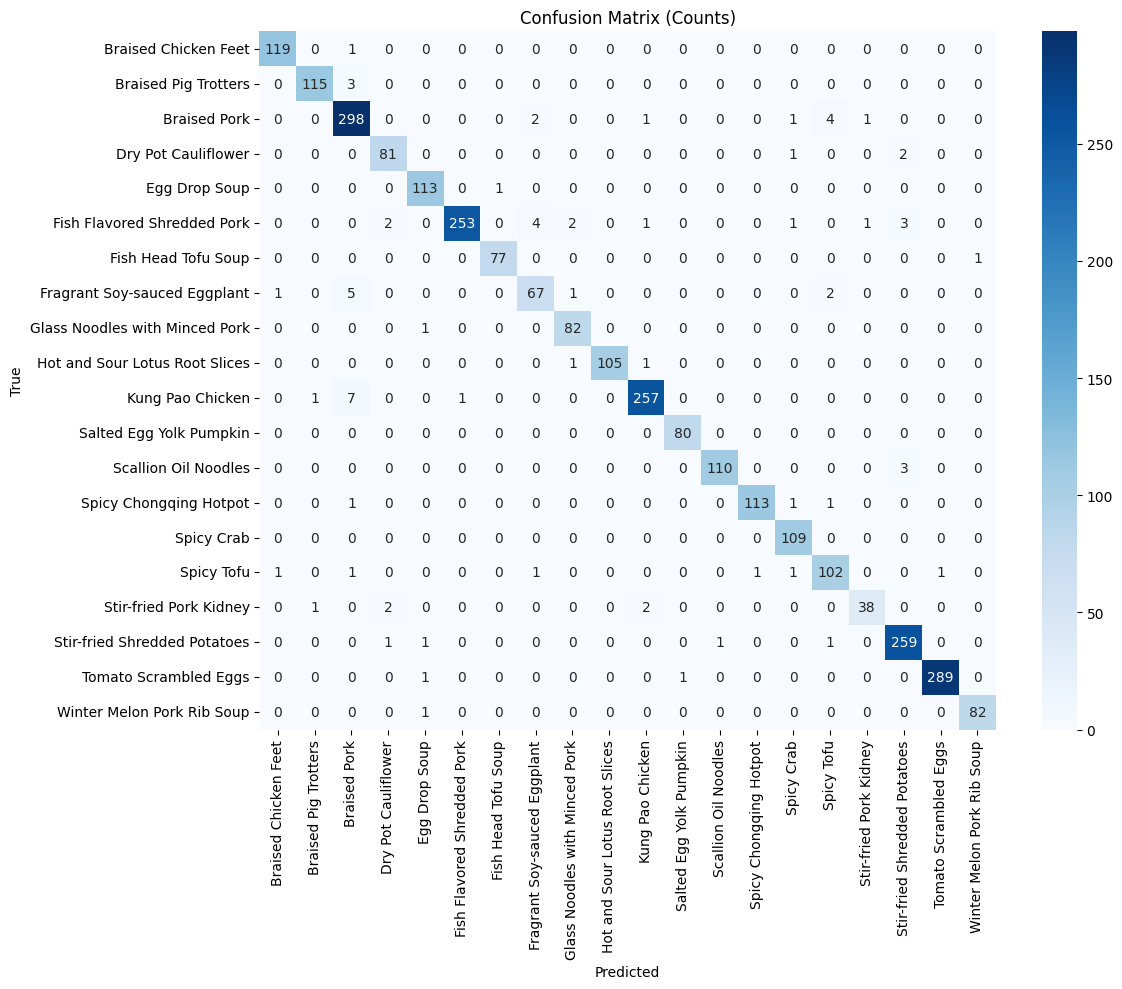

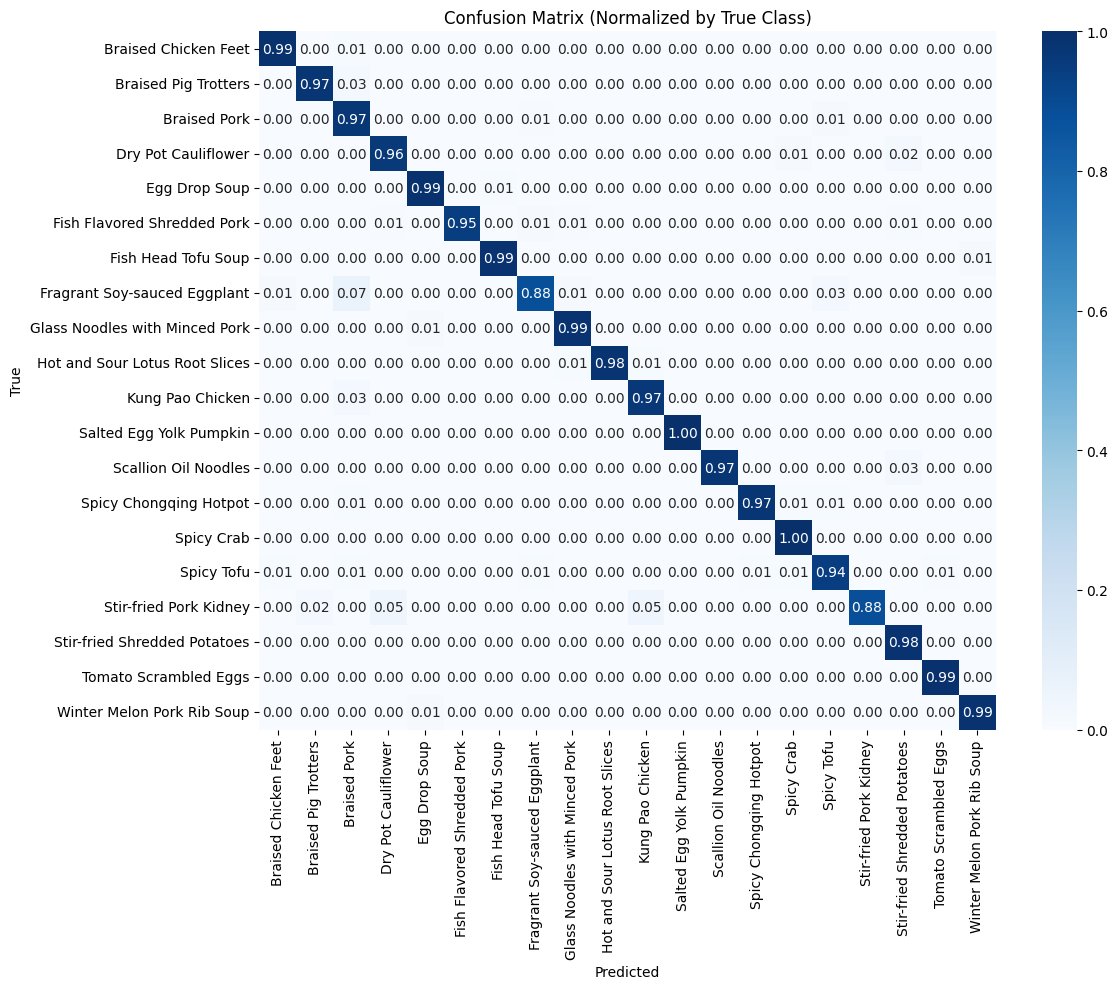

In [7]:
# confusion_matrix_from_saved.py
import json, pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# 1. Load model + class names
# -------------------------
loaded = keras.models.load_model("food_efficientnet_b0.keras")

with open("class_names.json", "r") as f:
    class_names = json.load(f)
num_classes = len(class_names)

# Wrap: accept 224×224 and resize to 256×256 for the saved model
inputs224 = keras.Input(shape=(224, 224, 3))
x = keras.layers.Resizing(256, 256, interpolation="bilinear")(inputs224)
outputs = loaded(x)
model = keras.Model(inputs224, outputs, name="wrapped_food_model")

# -------------------------
# 2. Build test dataset (224×224 RGB)
# -------------------------
DATA_DIR = pathlib.Path("dataset_split")
TEST_DIR = DATA_DIR / "test"
IMG_SIZE = (224, 224)
BATCH = 32

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False,
    color_mode="rgb",
)

# -------------------------
# 3. Get predictions
# -------------------------
y_true, y_pred = [], []
for batch_imgs, batch_labels in test_ds:
    probs = model.predict(batch_imgs, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    y_true.extend(batch_labels.numpy().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# -------------------------
# 4. Classification report
# -------------------------
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

# -------------------------
# 5. Confusion matrix
# -------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Counts)")
plt.tight_layout()
plt.show()

# Normalized (row-wise) confusion matrix
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(12, 10))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            vmin=0.0, vmax=1.0)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Normalized by True Class)")
plt.tight_layout()
plt.show()


In [9]:
import json, pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report

# --- Load model and class names ---
loaded = keras.models.load_model("food_efficientnet_b0.keras")
with open("class_names.json", "r") as f:
    class_names = json.load(f)

# Wrap so we can feed 224x224
inputs224 = keras.Input(shape=(224, 224, 3))
x = keras.layers.Resizing(256, 256, interpolation="bilinear")(inputs224)
outputs = loaded(x)
model = keras.Model(inputs224, outputs)

# --- Build test dataset: load as RGB to avoid GIF channel issues ---
DATA_DIR = pathlib.Path("dataset_split")
TEST_DIR = DATA_DIR / "test"
IMG_SIZE = (224, 224)
BATCH = 32

test_ds_rgb = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False,
    color_mode="rgb",           # important: load as RGB
)

# --- Convert RGB -> Grayscale -> back to 3 channels (gray triplet) ---
def rgb_to_gray_triplet(x, y):
    g1 = tf.image.rgb_to_grayscale(x)      # (B,H,W,1)
    g3 = tf.image.grayscale_to_rgb(g1)     # (B,H,W,3) — still grayscale (no color info)
    return g3, y

test_ds_gray3 = test_ds_rgb.map(rgb_to_gray_triplet, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_gray3 = test_ds_gray3.prefetch(tf.data.AUTOTUNE)

# --- Evaluate on grayscale (no color info) ---
y_true, y_pred = [], []
for batch_imgs, batch_labels in test_ds_gray3:
    probs = model.predict(batch_imgs, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    y_true.extend(batch_labels.numpy().tolist())

print("\nClassification Report (Grayscale Evaluation):\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))


Found 2826 files belonging to 20 classes.

Classification Report (Grayscale Evaluation):

                                precision    recall  f1-score   support

          Braised Chicken Feet      0.930     0.892     0.911       120
          Braised Pig Trotters      0.976     0.695     0.812       118
                  Braised Pork      0.543     0.964     0.695       307
           Dry Pot Cauliflower      0.637     0.857     0.731        84
                 Egg Drop Soup      0.690     0.781     0.733       114
   Fish Flavored Shredded Pork      0.896     0.839     0.867       267
           Fish Head Tofu Soup      0.621     0.923     0.742        78
  Fragrant Soy-sauced Eggplant      0.435     0.395     0.414        76
Glass Noodles with Minced Pork      0.729     0.940     0.821        83
Hot and Sour Lotus Root Slices      0.828     0.944     0.882       107
              Kung Pao Chicken      0.951     0.797     0.867       266
       Salted Egg Yolk Pumpkin      0.825    

In [10]:
# robustify_grayscale_finetune.py
import json, pathlib
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report

# ---- Config
DATA_DIR = pathlib.Path("dataset_split")
TRAIN_DIR = DATA_DIR / "train"
VAL_DIR   = DATA_DIR / "val"
IMG_SIZE  = (224, 224)
BATCH     = 32
EPOCHS    = 5
LR        = 1e-4

# ---- Datasets (RGB, 224x224)
def make_ds(path, shuffle):
    return tf.keras.utils.image_dataset_from_directory(
        path, labels="inferred", label_mode="int",
        image_size=IMG_SIZE, batch_size=BATCH, shuffle=shuffle,
        color_mode="rgb"
    )

train_ds = make_ds(TRAIN_DIR, True).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds   = make_ds(VAL_DIR,   False).cache().prefetch(tf.data.AUTOTUNE)

# ---- Load class names
with open("class_names.json", "r") as f:
    class_names = json.load(f)

# ---- RandomGrayscale layer
class RandomGrayscale(keras.layers.Layer):
    def __init__(self, p=0.5, **kw): super().__init__(**kw); self.p = p
    def call(self, x, training=False):
        if not training: return x
        b = tf.shape(x)[0]
        mask = tf.random.uniform([b,1,1,1]) < self.p
        g1 = tf.image.rgb_to_grayscale(x)
        g3 = tf.image.grayscale_to_rgb(g1)
        return tf.where(mask, g3, x)

# ---- Load saved model (expects 256x256), wrap to accept 224x224 + augment
loaded = keras.models.load_model("food_efficientnet_b0.keras")

inputs = keras.Input(shape=(224,224,3))
x = RandomGrayscale(p=0.5)(inputs)               # <-- key addition
x = keras.layers.Resizing(256,256)(x)            # match saved model input
outputs = loaded(x)
model = keras.Model(inputs, outputs, name="grayscale_robust_wrapper")

model.compile(
    optimizer=keras.optimizers.Adam(LR),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc"),
             keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top3")]
)

# ---- Fine-tune a few epochs
model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

# ---- Evaluate RGB test
TEST_DIR = DATA_DIR / "test"
test_ds_rgb = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, labels="inferred", label_mode="int",
    image_size=IMG_SIZE, batch_size=BATCH, shuffle=False, color_mode="rgb"
).prefetch(tf.data.AUTOTUNE)

y_true, y_pred = [], []
for x_batch, y_batch in test_ds_rgb:
    p = model.predict(x_batch, verbose=0)
    y_pred.extend(np.argmax(p, axis=1)); y_true.extend(y_batch.numpy().tolist())

print("\nClassification Report (RGB after grayscale fine-tune):\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

# ---- Evaluate Grayscale (no color info): RGB -> gray -> gray triplet
def rgb_to_gray_triplet(x, y):
    g1 = tf.image.rgb_to_grayscale(x); g3 = tf.image.grayscale_to_rgb(g1); return g3, y
test_ds_gray3 = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, labels="inferred", label_mode="int",
    image_size=IMG_SIZE, batch_size=BATCH, shuffle=False, color_mode="rgb"
).map(rgb_to_gray_triplet).prefetch(tf.data.AUTOTUNE)

y_true, y_pred = [], []
for x_batch, y_batch in test_ds_gray3:
    p = model.predict(x_batch, verbose=0)
    y_pred.extend(np.argmax(p, axis=1)); y_true.extend(y_batch.numpy().tolist())

print("\nClassification Report (Grayscale after fine-tune):\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))


Found 8479 files belonging to 20 classes.
Found 2745 files belonging to 20 classes.

Epoch 1/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 1827s 7s/step - acc: 0.8313 - loss: 0.5469 - top3: 0.9458 - val_acc: 0.9668 - val_loss: 0.1134 - val_top3: 0.9964
Epoch 2/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 2015s 8s/step - acc: 0.8619 - loss: 0.4391 - top3: 0.9645 - val_acc: 0.9647 - val_loss: 0.1193 - val_top3: 0.9971
Epoch 3/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 1935s 7s/step - acc: 0.8694 - loss: 0.4101 - top3: 0.9705 - val_acc: 0.9632 - val_loss: 0.1202 - val_top3: 0.9971
Epoch 4/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 1685s 6s/step - acc: 0.8762 - loss: 0.4030 - top3: 0.9699 - val_acc: 0.9636 - val_loss: 0.1202 - val_top3: 0.9971
Epoch 5/5
265/265 ━━━━━━━━━━━━━━━━━━━━ 1560s 6s/step - acc: 0.8733 - loss: 0.3963 - top3: 0.9697 - val_acc: 0.9650 - val_loss: 0.1185 - val_top3: 0.9971
Found 2826 files belonging to 20 classes.

Classification Report (RGB after grayscale fine-tune):

                                precision    recall

In [11]:
model.save("food_efficientnet_b0_grayscale_robust.keras")

In [34]:
import tensorflow as tf
from tensorflow import keras
import visualkeras

# 1) Build a fresh backbone with FIXED input shape (so shapes aren't None)
vis_backbone = keras.applications.EfficientNetB0(
    include_top=False,
    weights=None,                 # weights not needed to visualize
    input_shape=(256, 256, 3),
    name="efficientnetb0_vis",
)

# 2) Proper color_map: values must be dicts with 'fill' (and optionally 'outline')
color_map = {
    keras.layers.InputLayer:                {'fill': '#E0E0E0'},
    keras.layers.Conv2D:                    {'fill': '#F3C969'},
    keras.layers.DepthwiseConv2D:           {'fill': '#F3C969'},
    keras.layers.SeparableConv2D:           {'fill': '#F3C969'},
    keras.layers.BatchNormalization:        {'fill': '#A3D977'},
    keras.layers.Activation:                {'fill': '#7BC8F6'},
    keras.layers.ReLU:                      {'fill': '#7BC8F6'},
    keras.layers.Add:                       {'fill': '#B0BEC5'},
    keras.layers.Concatenate:               {'fill': '#B0BEC5'},
    keras.layers.AveragePooling2D:          {'fill': '#E4647F'},
    keras.layers.GlobalAveragePooling2D:    {'fill': '#E6A8E0'},
    keras.layers.ZeroPadding2D:             {'fill': '#95B3D7'},
}

# 3) Draw the “lego” diagram
visualkeras.layered_view(
    vis_backbone,
    to_file="efficientnet_backbone_pruned.png",
    legend=True,
    color_map=color_map,
    draw_volume=False,
    show_dimension=False,
    type_ignore=[
        keras.layers.BatchNormalization,
        keras.layers.Activation,
        keras.layers.ReLU,
        keras.layers.Add,
        keras.layers.ZeroPadding2D,
        keras.layers.Concatenate,
    ],
    scale_xy=0.35,
    spacing=3
)


print("Saved: efficientnet_backbone.png")


Saved: efficientnet_backbone.png
